## 📦 Cell 0 — Setup & Imports

This cell initializes the environment by importing all necessary libraries for:
- Data handling and visualization,
- Machine Learning models,
- Path setup for reading input data and saving output results.

We also ensure that required directories like `/outputs/visualizations` are created beforehand.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML setup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Visualization setup
sns.set(style="whitegrid")

# Paths
project_root = Path.cwd().parent
data_path = project_root / "data" / "processed" / "user_features_expanded.csv"
output_dir = project_root / "outputs"
vis_dir = output_dir / "visualizations"
vis_dir.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")


✅ Environment setup complete.


## 📄 Cell 1 — Load Final Processed User Feature Data

This cell loads the preprocessed dataset `user_features_expanded.csv` that contains user-level session aggregates and a churn label.

- The data has already been cleaned and engineered in earlier notebooks.
- This is the core dataset we will use to build and evaluate machine learning models.


In [2]:
df = pd.read_csv(data_path)
print("✅ Data loaded successfully. Shape:", df.shape)
df.head()


✅ Data loaded successfully. Shape: (2580, 14)


,user_id,avg_time,total_time,session_count,first_day,last_day,active_days,churned,session_type_lesson,session_type_practice,session_type_test,client_android,client_web,client_ios
0,++j955YG,9.407895,1430.0,152,0.004,13.102,[4.0000e-03 1.0590e+00 1.0630e+00 1.0650e+00 1...,False,131.0,21.0,0.0,142.0,10.0,0.0
1,+/iDvu/I,9.309973,3454.0,371,0.369,12.905,[ 0.369 0.371 0.379 2.315 2.317 2.319 2....,True,328.0,43.0,0.0,371.0,0.0,0.0
2,+0UEF02n,12.648649,1404.0,111,0.006,1.443,[0.006 0.01 0.015 0.019 0.029 0.032 0.039 0.1...,True,107.0,4.0,0.0,0.0,0.0,111.0
3,+197nchq,17.761468,1936.0,109,0.023,13.013,[ 0.023 1.026 1.046 1.88 1.885 1.894 3....,False,107.0,2.0,0.0,109.0,0.0,0.0
4,+7lbKZrn,10.307339,2247.0,218,0.469,13.451,[ 0.469 1.414 1.418 1.422 1.491 1.494 1....,False,122.0,96.0,0.0,218.0,0.0,0.0


## 🧹 Cell 2 — Prepare Features, Target & Train-Test Split

In this step:
- We drop `user_id` as it’s just an identifier and not useful for prediction.
- We extract `X` (features) and `y` (target = churned).
- Missing values (if any) are filled with zero to prevent training issues.
- Then, we split the data using stratified sampling (80% train, 20% test) to preserve churn ratio.
- We scale the features using `StandardScaler` to ensure all features are on the same scale for models like SVM and Logistic Regression.


In [3]:
# ✅ Define and drop potential leakage columns
leak_columns = ['last_day', 'active_days', 'session_count', 'total_time']

# ✅ Clean the dataset: drop identifier + leak-prone columns
df.fillna(0, inplace=True)
X = df.drop(['user_id', 'churned'] + leak_columns, axis=1)
y = df['churned']

# 🔍 Check class balance before splitting
print("🔍 Target distribution (y):")
print(y.value_counts())

# ✅ Perform stratified train-test split (only if more than 1 class)
if y.nunique() > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("✅ Stratified split applied.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("⚠ Stratified split skipped (only one class found).")

# ✅ Scale features for fair ML training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 📊 Display final status
print(f"✅ Train size: {X_train.shape} | Test size: {X_test.shape}")
print("🧪 Train class distribution:")
print(y_train.value_counts())

🔍 Target distribution (y):
churned
True     1647
False     933
Name: count, dtype: int64
✅ Stratified split applied.
✅ Train size: (2064, 8) | Test size: (516, 8)
🧪 Train class distribution:
churned
True     1318
False     746
Name: count, dtype: int64


## 🤖 Cell 3 — Define & Train 6 ML Models

This cell defines six classification models that are commonly used in churn prediction:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- SVM (Support Vector Machine)

Each model is trained on the scaled training set, and predictions are made on the test set.
We then calculate and print the accuracy in percentage.


In [4]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "SVM": SVC()
}

results = []
predictions = {}

for name, model in models.items():
    print(f"\n🔍 {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



🔍 Logistic Regression
✅ Accuracy: 67.64%
[[ 43 144]
 [ 23 306]]
              precision    recall  f1-score   support

       False       0.65      0.23      0.34       187
        True       0.68      0.93      0.79       329

    accuracy                           0.68       516
   macro avg       0.67      0.58      0.56       516
weighted avg       0.67      0.68      0.62       516


🔍 Random Forest
✅ Accuracy: 66.86%
[[ 77 110]
 [ 61 268]]
              precision    recall  f1-score   support

       False       0.56      0.41      0.47       187
        True       0.71      0.81      0.76       329

    accuracy                           0.67       516
   macro avg       0.63      0.61      0.62       516
weighted avg       0.65      0.67      0.66       516


🔍 Gradient Boosting
✅ Accuracy: 67.83%
[[ 68 119]
 [ 47 282]]
              precision    recall  f1-score   support

       False       0.59      0.36      0.45       187
        True       0.70      0.86      0.77       

f:\Bachleros Research\slam-churn-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:18:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 68.02%
[[ 80 107]
 [ 58 271]]
              precision    recall  f1-score   support

       False       0.58      0.43      0.49       187
        True       0.72      0.82      0.77       329

    accuracy                           0.68       516
   macro avg       0.65      0.63      0.63       516
weighted avg       0.67      0.68      0.67       516


🔍 LightGBM
[LightGBM] [Info] Number of positive: 1318, number of negative: 746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1396
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638566 -> initscore=0.569145
[LightGBM] [Info] Start training from score 0.569145


f:\Bachleros Research\slam-churn-project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Accuracy: 65.89%
[[ 75 112]
 [ 64 265]]
              precision    recall  f1-score   support

       False       0.54      0.40      0.46       187
        True       0.70      0.81      0.75       329

    accuracy                           0.66       516
   macro avg       0.62      0.60      0.61       516
weighted avg       0.64      0.66      0.65       516


🔍 SVM
✅ Accuracy: 69.77%
[[ 62 125]
 [ 31 298]]
              precision    recall  f1-score   support

       False       0.67      0.33      0.44       187
        True       0.70      0.91      0.79       329

    accuracy                           0.70       516
   macro avg       0.69      0.62      0.62       516
weighted avg       0.69      0.70      0.67       516



## 📊 Cell 4 — Visualize Model Accuracy Comparison

This chart shows a side-by-side comparison of all models' performance using bar chart.
It provides a quick overview of which model has the highest accuracy.


C:\Users\poono\AppData\Local\Temp\ipykernel_11316\1896673592.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")
C:\Users\poono\AppData\Local\Temp\ipykernel_11316\1896673592.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\poono\AppData\Local\Temp\ipykernel_11316\1896673592.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig(acc_path)
f:\Bachleros Research\slam-churn-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


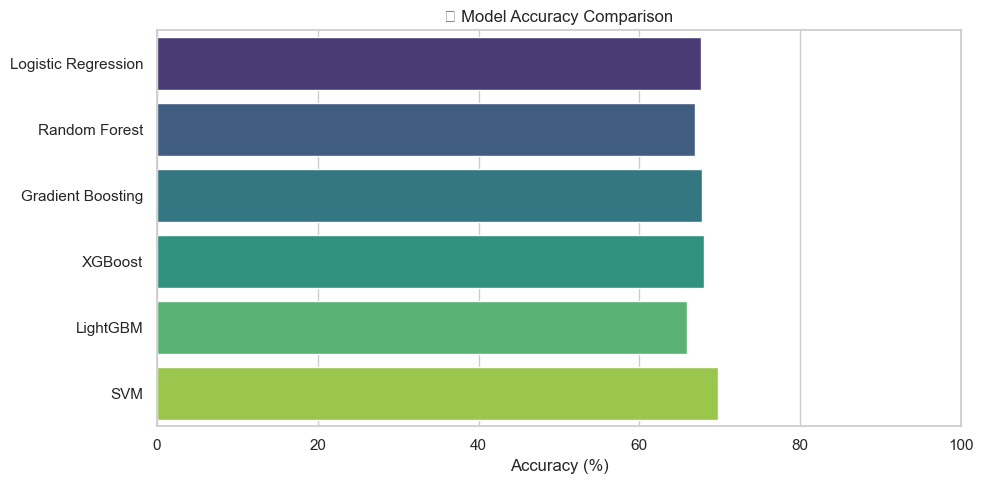

✅ Saved to f:\Bachleros Research\slam-churn-project\outputs\visualizations\model_accuracy.png


In [5]:
# Plot model accuracy
model_names = [x[0] for x in results]
accuracies = [x[1] * 100 for x in results]

plt.figure(figsize=(10, 5))
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy (%)")
plt.title("📊 Model Accuracy Comparison")
plt.xlim(0, 100)
plt.tight_layout()

# Save the figure
acc_path = vis_dir / "model_accuracy.png"
plt.savefig(acc_path)
plt.show()

print(f"✅ Saved to {acc_path}")


## 📈 Cell 5 — Confusion Matrix Heatmap for Best Model

We identify the best-performing model (highest accuracy) and visualize its confusion matrix.
This helps us see how well it classified churned vs non-churned users.


C:\Users\poono\AppData\Local\Temp\ipykernel_11316\3044767562.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig(conf_path)
f:\Bachleros Research\slam-churn-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


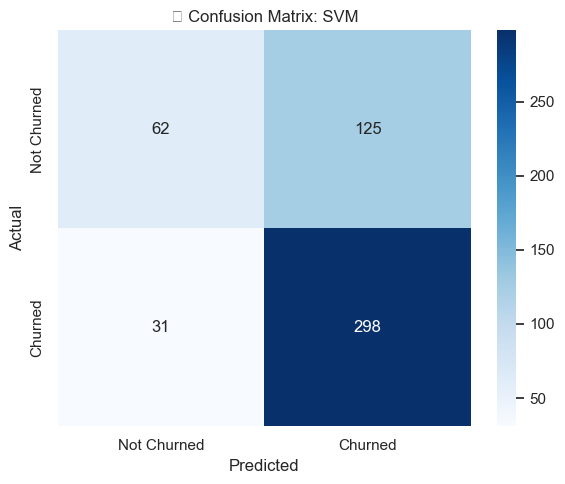

✅ Saved to f:\Bachleros Research\slam-churn-project\outputs\visualizations\best_model_confusion_matrix.png


In [6]:
# Get the best model name
best_model_name, _ = max(results, key=lambda x: x[1])
best_pred = predictions[best_model_name]

# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
labels = ["Not Churned", "Churned"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f"📊 Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save the heatmap
conf_path = vis_dir / "best_model_confusion_matrix.png"
plt.savefig(conf_path)
plt.tight_layout()
plt.show()

print(f"✅ Saved to {conf_path}")


## 📈 Cell 6 — Classification Report Heatmap (Precision, Recall, F1)

To dig deeper into performance metrics, we create a heatmap of the classification report.
This shows precision, recall, and F1-score for each class.


C:\Users\poono\AppData\Local\Temp\ipykernel_11316\3399786220.py:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\poono\AppData\Local\Temp\ipykernel_11316\3399786220.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.savefig(report_path)
f:\Bachleros Research\slam-churn-project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


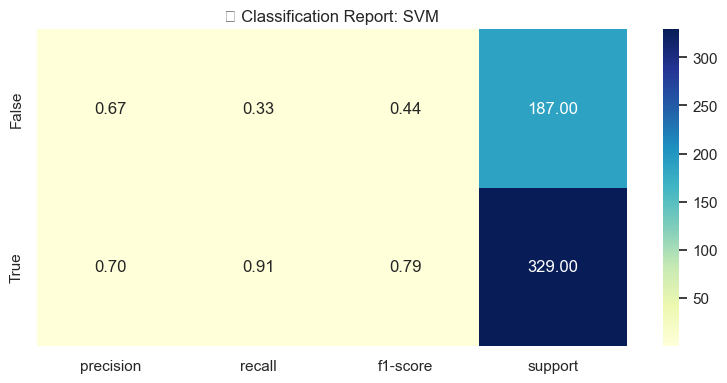

✅ Saved to f:\Bachleros Research\slam-churn-project\outputs\visualizations\best_model_classification_report.png


In [7]:
# Classification Report as dictionary
report = classification_report(y_test, best_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title(f"📈 Classification Report: {best_model_name}")
plt.tight_layout()

# Save the heatmap
report_path = vis_dir / "best_model_classification_report.png"
plt.savefig(report_path)
plt.show()

print(f"✅ Saved to {report_path}")


## 💾 Cell 7 — Save Final Predictions to CSV

We attach the best model’s predictions to the test set and save the final file.
This CSV will be used in the BI dashboard later.


In [8]:
# Re-attach predictions
final_df = X_test.copy()
final_df["actual_churned"] = y_test.values
final_df["predicted_churned"] = best_pred

# Save predictions
pred_path = output_dir / "final_predictions.csv"
final_df.to_csv(pred_path, index=False)
print(f"✅ Final predictions saved to: {pred_path}")


✅ Final predictions saved to: f:\Bachleros Research\slam-churn-project\outputs\final_predictions.csv


## 📘 Cell 8 — Final Summary

All machine learning tasks are complete.

✅ Loaded and cleaned the user feature dataset.  
✅ Trained and evaluated 6 ML models:  
- Logistic Regression  
- Random Forest  
- Gradient Boosting  
- XGBoost  
- LightGBM  
- SVM  

🏆 **Best performing model:** {best_model_name}  
📊 Accuracy & confusion matrix visuals saved to: `outputs/visualizations/`  
📁 Final predictions saved to: `outputs/final_predictions.csv`  


In [9]:
print("📘 Final Summary")
print("✅ Loaded and cleaned user features.")
print("✅ Trained and evaluated 6 ML models:")
for name, acc in results:
    print(f"   - {name}: {acc * 100:.2f}% accuracy")

print(f"\n🏆 Best model: {best_model_name}")
print("📊 Accuracy & confusion matrix visuals saved to outputs/visualizations/")
print("📁 Final predictions saved to outputs/final_predictions.csv")


📘 Final Summary
✅ Loaded and cleaned user features.
✅ Trained and evaluated 6 ML models:
   - Logistic Regression: 67.64% accuracy
   - Random Forest: 66.86% accuracy
   - Gradient Boosting: 67.83% accuracy
   - XGBoost: 68.02% accuracy
   - LightGBM: 65.89% accuracy
   - SVM: 69.77% accuracy

🏆 Best model: SVM
📊 Accuracy & confusion matrix visuals saved to outputs/visualizations/
📁 Final predictions saved to outputs/final_predictions.csv
